In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from auxiliary import plot_boundary, plot_svm_margins
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error, 
                             mean_absolute_percentage_error)

sns.set()

# Support Vector Machines

## SVM como regresión

Como vimos en clase, SVM tambien se puede usar para realizar regresiones. Scikit-learn nos ofrece la clase [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) que es la implementación de SVM para regresión. 

Para practicar este modelo, vamos a usar el dataset **Hitters**, el cual contiene datos de jugadores de beisbol de la liga estadounidense de 1986 y 1987. Contiene 322 observaciones con 20 datos. Este conjunto de datos se tomó de la biblioteca StatLib que se mantiene en la Universidad Carnegie Mellon. Los datos salariales fueron originalmente de Sports Illustrated, 20 de abril de 1987. Las estadísticas de 1986 y de carrera se obtuvieron de The 1987 Baseball Encyclopedia Update publicado por Collier Books, Macmillan Publishing Company, Nueva York. Que significa cada cosa está [explicado aquí](https://rdrr.io/cran/ISLR/man/Hitters.html).

Lo que queremos hacer es tener alguna regresión de los salarios de 1987 los jugadores usando como base los datos de ellos de su perfomance en 1986.

In [2]:
# Cargamos el dataset
df_hitters = pd.read_csv("datasets/Hitters.csv")

In [3]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [4]:
df_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [5]:
# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

In [6]:
# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])

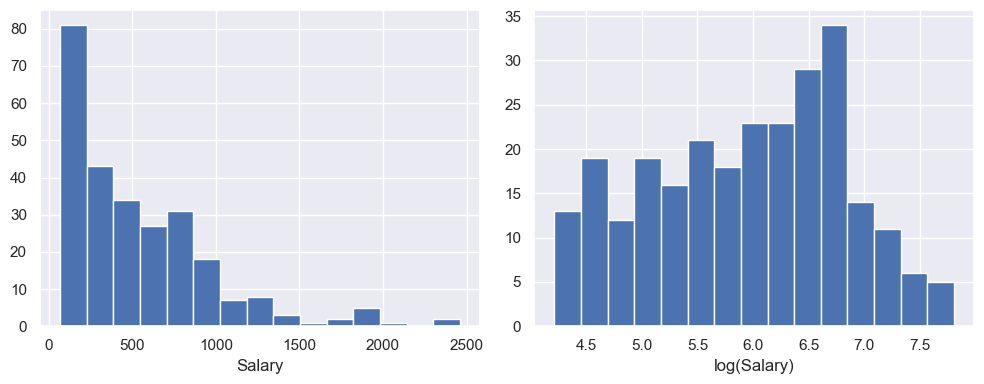

In [7]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
df_hitters["Salary"].hist(ax=ax[0], bins=15)
df_hitters["Salary_log"].hist(ax=ax[1], bins=15)

ax[0].set_xlabel("Salary")
ax[1].set_xlabel("log(Salary)")
plt.tight_layout()

Como podemos ver, mejoramos la dispersión de datos, principalmente aquellos que están en los primeros bins.

Tenemos todas variables numéricas, menos *League*, *Division* y *NewLeague*, que vamos a obtener las variables dummy de ellas:

In [8]:
df_hitters.League.value_counts()

League
A    139
N    124
Name: count, dtype: int64

In [9]:
df_hitters.Division.value_counts()

Division
W    134
E    129
Name: count, dtype: int64

In [10]:
df_hitters.NewLeague.value_counts()

NewLeague
A    141
N    122
Name: count, dtype: int64

In [11]:
df_hitters_dummies = pd.get_dummies(data=df_hitters, 
                                    columns=['League', 'Division', 'NewLeague'],
                                    drop_first=True)

In [12]:
df_hitters_dummies.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'Salary_log', 'League_N', 'Division_W',
       'NewLeague_N'],
      dtype='object')

Obtenemos los arrays.

In [13]:
X_cols = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 
          'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 
          'Division_W', 'NewLeague_N']

X = df_hitters_dummies.loc[:, X_cols]
# Y como variable a predecir a Salary
y = df_hitters_dummies.loc[:, 'Salary_log']

Separamos en el dataset de entrenamiento y testeo.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora escalamos las variables.

In [16]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Vamos a realizar otra búsqueda de hiper-parametros para evaluar el modelo, solo que ahora como métrica vamos a usar MAE, dado que estamos en un caso de regresión:

In [33]:
from sklearn.svm import SVR

svm_hitters = SVR()

grid = GridSearchCV(svm_hitters,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf", "sigmoid"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'gamma': [0.1, 0.5, 1, 2, 10, 100],
                          'kernel': ['rbf', 'sigmoid']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']}],
             scoring='neg_mean_absolute_error')

In [34]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Según esta busqueda el mejor modelo es uno con función radial.

Evaluemos este modelo con el set de testeo.

In [35]:
y_pred = grid.predict(X_test)

# equivalente:
# svm_hitters_best = grid.best_estimator_
# y_pred = svm_hitters_best.predict(X_test)

In [36]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.39175772460027924
RMSE de testeo fue: 0.5702031555139373
MAPE de testeo fue: 0.06831807029280873
R2 de testeo fue: 0.5828398458336197


Este modelo tuvo un error de testeo de 0.39. 

Comparemos este modelo con una regresión Ridge, para lo cual primero hacemos una búsqueda de hiper-parámetros:

In [37]:
from sklearn.linear_model import Ridge

ridge_hitters = Ridge()

grid = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.02002002,  0.04004004,  0.06006006,  0.08008008,
        0.1001001 ,  0.12012012,  0.14014014,  0.16016016,  0.18018018,
        0.2002002 ,  0.22022022,  0.24024024,  0.26026026,  0.28028028,
        0.3003003 ,  0.32032032,  0.34034034,  0.36036036,  0.38038038,
        0.4004004 ,  0.42042042,  0.44044044,  0.46046046,  0.48048048,
        0.5005005 ,  0.52052052,  0.5...
       19.41941942, 19.43943944, 19.45945946, 19.47947948, 19.4994995 ,
       19.51951952, 19.53953954, 19.55955956, 19.57957958, 19.5995996 ,
       19.61961962, 19.63963964, 19.65965966, 19.67967968, 19.6996997 ,
       19.71971972, 19.73973974, 19.75975976, 19.77977978, 19.7997998 ,
       19.81981982, 19.83983984, 19.85985986, 19.87987988, 19.8998999 ,
       19.91991992, 19.93993994, 19.95995996, 19.97997998, 20.        ])},
             scoring='neg_mean_absolute_error')

In [38]:
grid.best_params_

{'alpha': 15.655655655655655}

In [39]:
ridge_hitters = grid.best_estimator_
y_pred_r = ridge_hitters.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_r)
rmse = root_mean_squared_error(y_test, y_pred_r)
mape = mean_absolute_percentage_error(y_test, y_pred_r)
r2 = r2_score(y_test, y_pred_r)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.5116774668312871
RMSE de testeo fue: 0.6621084105396078
MAPE de testeo fue: 0.09039887103089116
R2 de testeo fue: 0.4375268502616785


Vemos que la regresión SVR que armamos mejoró un 23% con respecto a la regresión de Ridge.